Email spam detection bot using Tensorflow

Import necessary modules

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

Reading the dataset

In [45]:
data=pd.read_csv('emails.csv')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [46]:
data.shape

(5728, 2)

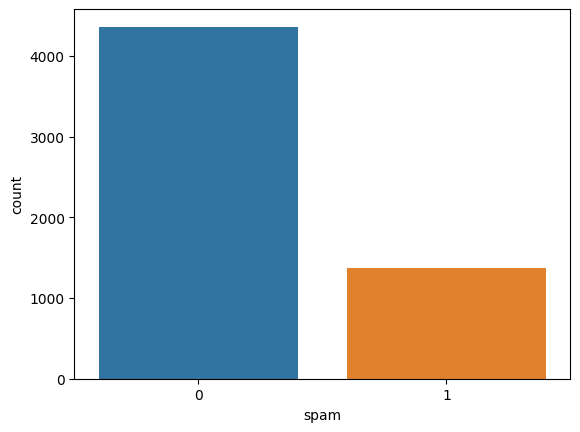

In [47]:
sns.countplot(x="spam",data=data)
plt.show()

We can clearly see that the number of spam samples is much lesser than the number of ham samples. This indicates that the dataset is unbalanced.

We will now attempt to balance the dataset.

Text(0.5, 0, 'Message types')

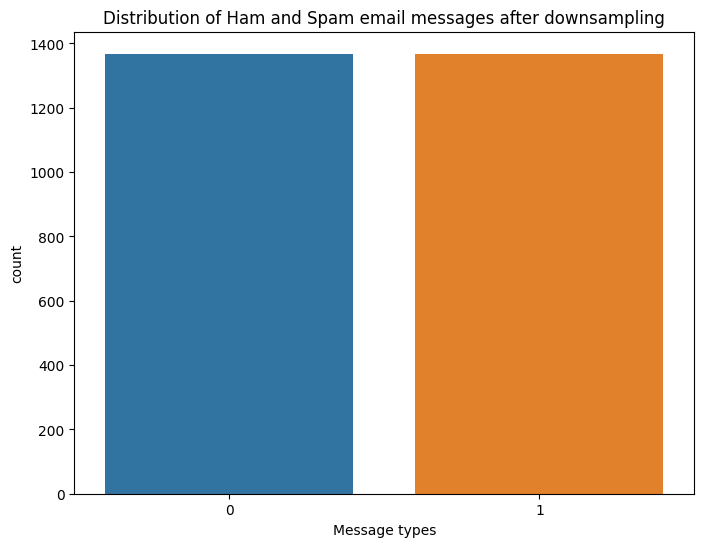

In [48]:
# Downsampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),random_state=42)

# Plotting the counts of down sampled dataset


balanced_data = pd.concat([ham_msg,spam_msg])
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

Text Preprocessing

In this section we will perform the following tasks on the text data

-Stopword Removal

-Punctuation Removal

-Stemming or Lemmatization

In [49]:
balanced_data['text']=balanced_data['text'].str.replace('Subject','')
balanced_data.head()

,text,spam
1547,: interview schedule for jinbaek kim i didn '...,0
2730,": re : wednesday meeting eric , i think we c...",0
4843,: re : london research group i ' d do it as s...,0
2856,": re : congratulations vince , thanks for you...",0
3804,: osman sezgen steve kromer is requesting tha...,0


In [50]:
punctuations_list=string.punctuation
def remove_punctuation(text):
    temp=str.maketrans('','',punctuations_list)
    return text.translate(temp)

balanced_data['text']=balanced_data['text'].apply(lambda x: remove_punctuation(x))
balanced_data.head()

,text,spam
1547,interview schedule for jinbaek kim i didn t...,0
2730,re wednesday meeting eric i think we can ...,0
4843,re london research group i d do it as soon...,0
2856,re congratulations vince thanks for your n...,0
3804,osman sezgen steve kromer is requesting that...,0


In [51]:
def remove_stopword(text):
    stop_words=stopwords.words('english')

    imp_words=[]

    # storing the important words
    for word in str(text).split():
        word=word.lower()

        if word not in stop_words:
            imp_words.append(word)
        
    output=" ".join(imp_words)

    return output

balanced_data['text']=balanced_data['text'].apply(lambda text: remove_stopword(text))
balanced_data.head()

,text,spam
1547,interview schedule jinbaek kim see went happy ...,0
2730,wednesday meeting eric think skip meeting disc...,0
4843,london research group soon possible call exact...,0
2856,congratulations vince thanks note congratulati...,0
3804,osman sezgen steve kromer requesting osman spe...,0


We will now plot a word cloud. A word cloud is a text visualization tool that helps us to get insights into the most frequent words present in the corpus of the data.

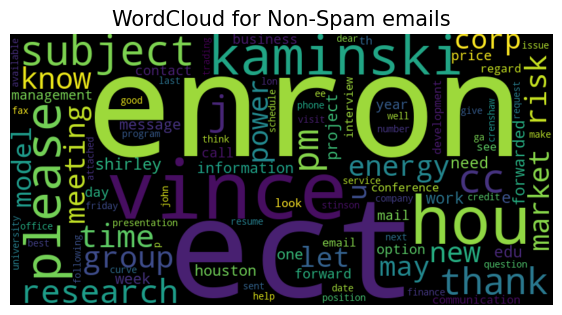

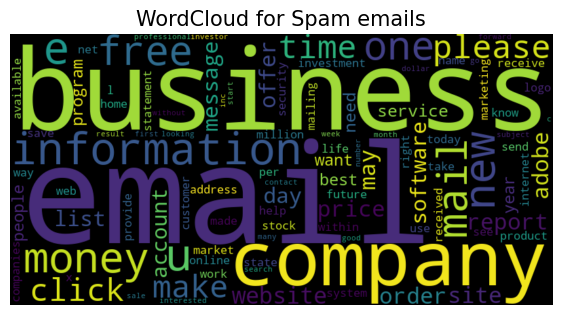

In [52]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['text'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

Word to vector conversion

We convert our words into vectors with the token ID's. We do this since machine learning models cannot be fed text data.

In [53]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
													balanced_data['spam'],
													test_size = 0.2,
													random_state = 42)


We have fitted the tokenizer on our training data. We will use it to convert the training and validation data both to vectors.

In [54]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')

Model Development and Evaluation

We are implementing a sequential model with the following parts

1. Three embedding layers to learn featured vector representation of the input vectors

2. An LSTM layer to identify useful patterns in the sequence

3. Then we will have one fully connected layer

4. Final layer is the output layer

In [55]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
									output_dim=32,
									input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu')) #relu is rectified linear activation unit
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 32)           805024    
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 808,737
Trainable params: 808,737
Non-trainable params: 0
_________________________________________________________________


While compiling a model we provide these three essential parameters:

optimizer – This is the method that helps to optimize the cost function by using gradient descent.

loss – The loss function by which we monitor whether the model is improving with training or not.

metrics – This helps to evaluate the model by predicting the training and the validation data.

In [56]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'],
            optimizer='adam')

Callback

Callbacks are used to check if the model performance in imporving with each epoch. If the model does not appear to improving with each epoch then training can be stopped by EarlyStopping. We can also define some custon callbacks that we can use to stop training if the desired outcomes have been achieved.

In [57]:
es=EarlyStopping(patience=3,monitor='val_accuracy',restore_best_weights=True)
lr=ReduceLROnPlateau(patience=2,monitor='val_loss',factor=0.5,verbose=0)

Now we train the model

In [58]:
history=model.fit(train_sequences,train_Y,validation_data=(test_sequences,test_Y),epochs=20,batch_size=32,callbacks=[es,lr])

Epoch 1/20
69/69 [==============================] - 4s 37ms/step - loss: 0.6516 - accuracy: 0.6367 - val_loss: 0.4741 - val_accuracy: 0.8029 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 2s 32ms/step - loss: 0.2125 - accuracy: 0.9543 - val_loss: 0.1210 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 2s 32ms/step - loss: 0.0997 - accuracy: 0.9813 - val_loss: 0.1033 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 2s 32ms/step - loss: 0.0453 - accuracy: 0.9931 - val_loss: 0.0777 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 2s 32ms/step - loss: 0.0289 - accuracy: 0.9959 - val_loss: 0.0929 - val_accuracy: 0.9818 - lr: 0.0010
Epoch 6/20
69/69 [==============================] - 2s 33ms/step - loss: 0.0151 - accuracy: 0.9982 - val_loss: 0.0790 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 7/20
69/69 [==============================] - 2s 32ms/step - loss: 0.0

Evaluate model on validation data

In [59]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

18/18 [==============================] - 0s 5ms/step - loss: 0.0777 - accuracy: 0.9854
Test Loss : 0.07774370908737183
Test Accuracy : 0.985401451587677


Model evaluation results

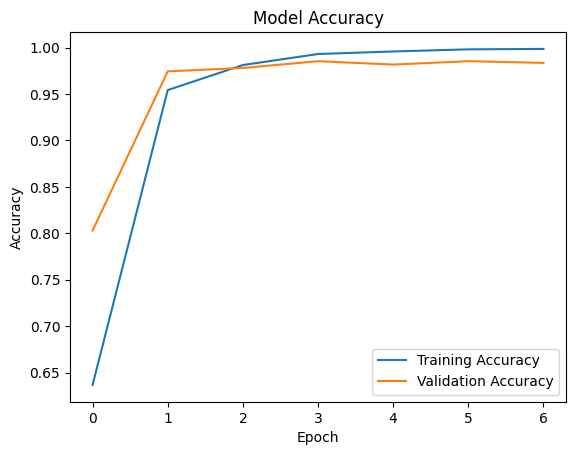

In [60]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()